<h1><b>Results<b><h1>
SVM Best Accuracies

5000-BoW: 78.2%
C = 10
gamma = 0.01
kernel = rbf

Word Emb: 70.5%
C = 10
gamma = 0.01
kernel = rbf

2-GRAM  : 69.5%
C = 1
gamma = scale
kernel = rbf

TF-IDF  : 60.5%
C = 10
gamma = scale
kernel = linear

In [9]:
import config
import constants
import pandas as pd
from sentiment_preprocessor import SentimentPreprocessor
from sentiment_preprocessor import combine_all_datasets
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split, GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

PATH_TO_DATA = "../alt/data/Combined"

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

def sample_labels(num_samples_per_label, X, y):
    list_of_labels = [-1, 0, 1]
    samples = {label: [] for label in list_of_labels}
    counts = {label: 0 for label in list_of_labels}
    for index in range(0, len(y), 1):
        label = y[index]
        if counts[label] >= num_samples_per_label:
            if sum(counts.values()) >= num_samples_per_label * len(list_of_labels):
                break
            continue
        samples[label].append(index)
        counts[label] += 1 
    all_samples = np.concatenate([samples[label] for label in list_of_labels])
    np.random.seed(constants.SEED)
    np.random.shuffle(all_samples)
    return X.filter(items = all_samples, axis=0), y.filter(items = all_samples, axis=0)

In [10]:
df = pd.read_csv(constants.PATH_TO_WE + "/../../alt/data/Combined/word_embedding/train.csv", index_col=False, header=None)
comments = df[df.columns[:-1]]
labels = df[df.columns[-1]]

counts = {-1: 0, 0: 0, 1: 0}
index = 0
for label in labels:
    counts[label] += 1
    index += 1
print(counts)

{-1: 9000, 0: 9000, 1: 9000}


<h1><b>Bag of Words<b><h1>

In [16]:
#load data
df_train_bow = pd.read_csv(PATH_TO_DATA + "/BoW/5000train.csv", header=None)
df_test_bow = pd.read_csv(PATH_TO_DATA + "/BoW/5000test.csv", header=None)

word_file = open(PATH_TO_DATA + "/BoW/5000BoW.txt", "r", encoding="utf-8")
words = [word.strip() for word in word_file]

X_train = df_train_bow[df_train_bow.columns[:-1]]
y_train = df_train_bow[df_train_bow.columns[-1]]
X_test = df_test_bow[df_test_bow.columns[:-1]]
y_test = df_test_bow[df_test_bow.columns[-1]]

X_train, y_train = sample_labels(9000, X_train, y_train)
X_test, y_test = sample_labels(2000, X_test, y_test)

X_train.columns = words
X_test.columns = words

In [10]:
counts = {-1: 0, 0: 0, 1: 0}
for label in y_train:
    counts[label] += 1
print(counts)

{-1: 9000, 0: 9000, 1: 9000}


In [12]:
#From tests in svm_word_frequency the best parameters are
#C = 10
#gamma = 0.01
#kernel = rbf
svm_bow = SVC(decision_function_shape='ovr', C=10, gamma=0.01, kernel="rbf")
svm_bow.fit(X_train, y_train)

SVC(C=10, gamma=0.01)


SVM with BoW Results:
Accuracy: 0.782
              precision    recall  f1-score   support

          -1       0.80      0.74      0.77      2000
           0       0.76      0.85      0.80      2000
           1       0.79      0.76      0.77      2000

    accuracy                           0.78      6000
   macro avg       0.78      0.78      0.78      6000
weighted avg       0.78      0.78      0.78      6000



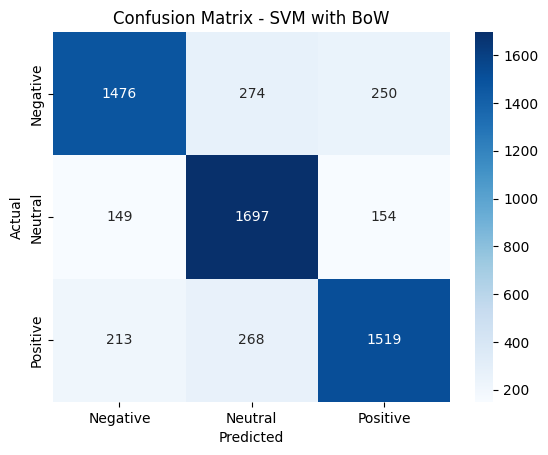

In [ ]:
#Test model
y_tuned = svm_bow.predict(X_test)
print("\nSVM with BoW Results:")
print("Accuracy:", accuracy_score(y_test, y_tuned))
print(classification_report(y_test, y_tuned))
plot_confusion_matrix(y_test, y_tuned, "Confusion Matrix - SVM with BoW")

#Accuracy of 78.2%

<h1><b>Word Embeddings<b><h1>

In [34]:
#load data
df_train_we = pd.read_csv(PATH_TO_DATA + "/word_embedding/train.csv", header=None)
df_test_we = pd.read_csv(PATH_TO_DATA + "/word_embedding/test.csv", header=None)

X_train = df_train_we[df_train_we.columns[:-1]]
y_train = df_train_we[df_train_we.columns[-1]]
X_test = df_test_we[df_test_we.columns[:-1]]
y_test = df_test_we[df_test_we.columns[-1]]

X_test, y_test = sample_labels(2000, X_test, y_test)

print(X_train.shape)
print(len(y_train))

(27000, 768)
27000


In [35]:
#From tests in svm_word_frequency the best parameters are
#C = 10
#gamma = 0.01
#kernel = rbf
svm_we = SVC(decision_function_shape='ovr', C=1, gamma="scale", kernel="rbf")
svm_we.fit(X_train, y_train)

SVC(C=1)


SVM with Word Embeddings Results:
Accuracy: 0.6953333333333334
              precision    recall  f1-score   support

          -1       0.65      0.73      0.69      2000
           0       0.70      0.72      0.71      2000
           1       0.75      0.63      0.68      2000

    accuracy                           0.70      6000
   macro avg       0.70      0.70      0.70      6000
weighted avg       0.70      0.70      0.70      6000



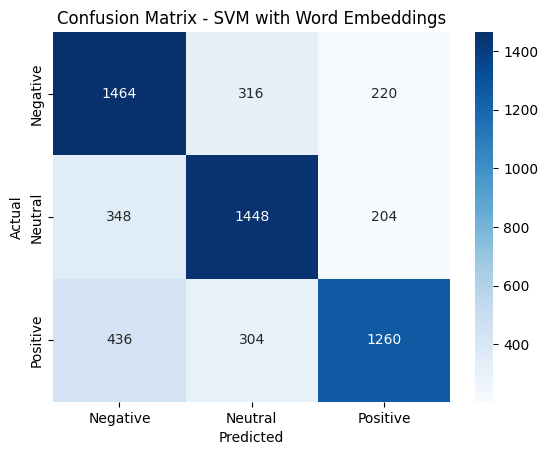

In [36]:
#Test model
y_tuned = svm_we.predict(X_test)
print("\nSVM with Word Embeddings Results:")
print("Accuracy:", accuracy_score(y_test, y_tuned))
print(classification_report(y_test, y_tuned))
plot_confusion_matrix(y_test, y_tuned, "Confusion Matrix - SVM with Word Embeddings")

#Accuracy of 70.5%

In [37]:
svm_we = SVC(decision_function_shape='ovr', C=1, kernel="linear")
svm_we.fit(X_train, y_train)

SVC(C=1, kernel='linear')


SVM with Word Embeddings Results:
Accuracy: 0.6863333333333334
              precision    recall  f1-score   support

          -1       0.64      0.71      0.67      2000
           0       0.70      0.70      0.70      2000
           1       0.73      0.65      0.69      2000

    accuracy                           0.69      6000
   macro avg       0.69      0.69      0.69      6000
weighted avg       0.69      0.69      0.69      6000



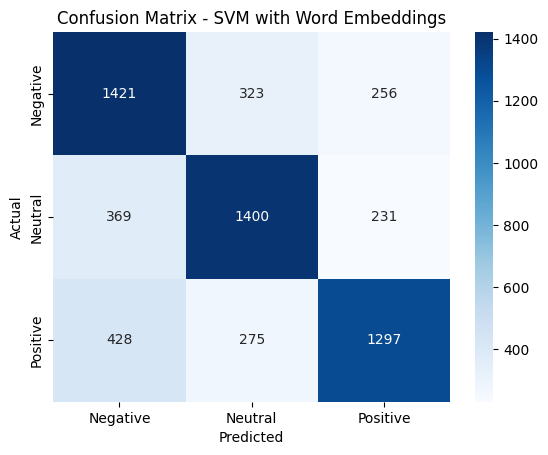

In [38]:
#Test model
y_tuned = svm_we.predict(X_test)
print("\nSVM with Word Embeddings Results:")
print("Accuracy:", accuracy_score(y_test, y_tuned))
print(classification_report(y_test, y_tuned))
plot_confusion_matrix(y_test, y_tuned, "Confusion Matrix - SVM with Word Embeddings")

In [39]:
svm_we = SVC(decision_function_shape='ovr', C=10, gamma=0.01, kernel="rbf")
svm_we.fit(X_train, y_train)

SVC(C=10, gamma=0.01)


SVM with Word Embeddings Results:
Accuracy: 0.7055
              precision    recall  f1-score   support

          -1       0.65      0.73      0.69      2000
           0       0.72      0.71      0.72      2000
           1       0.75      0.67      0.71      2000

    accuracy                           0.71      6000
   macro avg       0.71      0.71      0.71      6000
weighted avg       0.71      0.71      0.71      6000



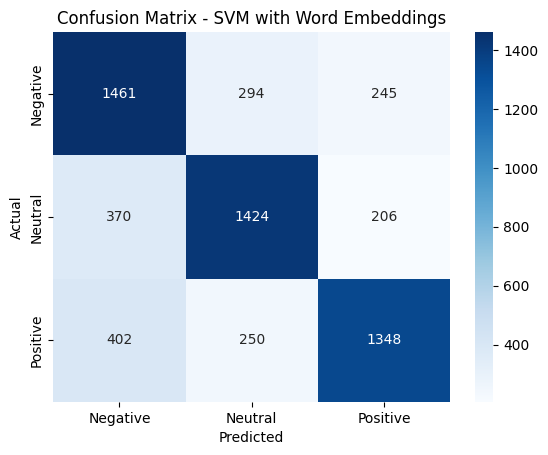

In [40]:
#Test model
y_tuned = svm_we.predict(X_test)
print("\nSVM with Word Embeddings Results:")
print("Accuracy:", accuracy_score(y_test, y_tuned))
print(classification_report(y_test, y_tuned))
plot_confusion_matrix(y_test, y_tuned, "Confusion Matrix - SVM with Word Embeddings")

<h1><b>N-Grams (2-Gram)<b><h1>

In [ ]:
#load data
df_train_ngram = pd.read_csv(PATH_TO_DATA + "/NGram/5000train.csv", header=None)
df_test_ngram = pd.read_csv(PATH_TO_DATA + "/NGram/5000test.csv", header=None)

X_train = df_train_ngram[df_train_ngram.columns[:-1]]
y_train = df_train_ngram[df_train_ngram.columns[-1]]
X_test = df_test_ngram[df_test_ngram.columns[:-1]]
y_test = df_test_ngram[df_test_ngram.columns[-1]]

X_train, y_train = sample_labels(500, X_train, y_train)
X_test, y_test = sample_labels(2000, X_test, y_test)

In [41]:
#tune
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_train, y_train, test_size=0.2, random_state=constants.SEED)

param_grid = {
    'C': [0.1, 1, 10],  # Regularization strength
    'kernel': ['linear'],  # Different kernel types
}

grid_search = GridSearchCV(SVC(decision_function_shape='ovr', verbose=True), param_grid, cv=5, scoring='accuracy', n_jobs=4, verbose=1)
grid_search.fit(X_train_, y_train_)

best_params = grid_search.best_params_
print(f"Best Parameters Found: {best_params}")

Fitting 5 folds for each of 3 candidates, totalling 15 fits


KeyboardInterrupt: 

In [42]:
#tune
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_train, y_train, test_size=0.2, random_state=constants.SEED)

param_grid = {
    'C': [0.1, 1, 10],  # Regularization strength
    'kernel': ['rbf'],  # Different kernel types
    'gamma': [0.001, 0.01, 0.1, 'scale', 'auto']  # Only relevant for non-linear kernels
}

grid_search = GridSearchCV(SVC(decision_function_shape='ovr', verbose=True), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_, y_train_)

best_params = grid_search.best_params_
print(f"Best Parameters Found: {best_params}")

[LibSVM]Best Parameters Found: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}


In [43]:
#Best parameters
#C = 1
#gamma = scale
#kernel = rbf
svm_ngram = SVC(decision_function_shape='ovr', C=1, gamma="scale", kernel="rbf")
svm_ngram.fit(X_train, y_train)

SVC(C=1)


SVM with 2-Gram N-Grams Results:
Accuracy: 0.6953333333333334
              precision    recall  f1-score   support

          -1       0.65      0.73      0.69      2000
           0       0.70      0.72      0.71      2000
           1       0.75      0.63      0.68      2000

    accuracy                           0.70      6000
   macro avg       0.70      0.70      0.70      6000
weighted avg       0.70      0.70      0.70      6000



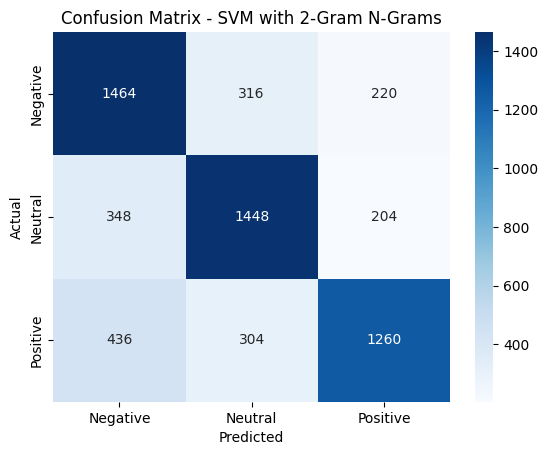

In [44]:
#Test model
y_tuned = svm_ngram.predict(X_test)
print("\nSVM with 2-Gram N-Grams Results:")
print("Accuracy:", accuracy_score(y_test, y_tuned))
print(classification_report(y_test, y_tuned))
plot_confusion_matrix(y_test, y_tuned, "Confusion Matrix - SVM with 2-Gram N-Grams")

In [ ]:
#Best parameters
#C = 1
#kernel = linear
svm_ngram = SVC(decision_function_shape='ovr', C=1, kernel="linear")
svm_ngram.fit(X_train, y_train)


SVM with 2-Gram N-Grams Results:
Accuracy: 0.6953333333333334
              precision    recall  f1-score   support

          -1       0.65      0.73      0.69      2000
           0       0.70      0.72      0.71      2000
           1       0.75      0.63      0.68      2000

    accuracy                           0.70      6000
   macro avg       0.70      0.70      0.70      6000
weighted avg       0.70      0.70      0.70      6000



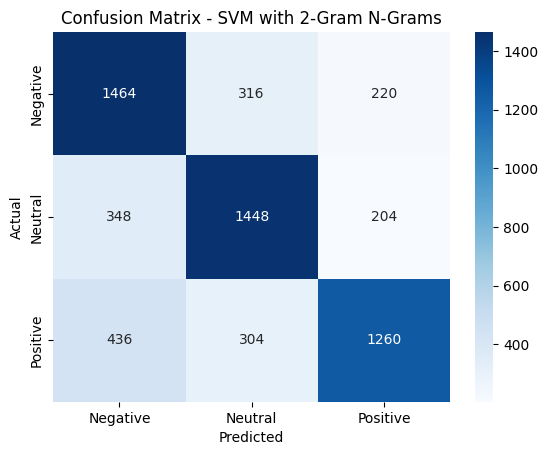

In [46]:
#Test model
y_tuned = svm_ngram.predict(X_test)
print("\nSVM with 2-Gram N-Grams Results:")
print("Accuracy:", accuracy_score(y_test, y_tuned))
print(classification_report(y_test, y_tuned))
plot_confusion_matrix(y_test, y_tuned, "Confusion Matrix - SVM with 2-Gram N-Grams")

<h1><b>TF-IDF Scores<b><h1>

In [ ]:
#load data
df_train_tfidf = pd.read_csv(PATH_TO_DATA + "")
df_test_tfidf = pd.read_csv(PATH_TO_DATA + "")

X_train = df_train_tfidf[df_train_tfidf.columns[:-1]]
y_train = df_train_tfidf[df_train_tfidf.columns[-1]]
X_test = df_test_tfidf[df_test_tfidf.columns[:-1]]
y_test = df_test_tfidf[df_test_tfidf.columns[-1]]

X_train, y_train = sample_labels(9000, X_train, y_train)

In [ ]:
#tune
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_train, y_train, test_size=0.2, random_state=constants.SEED)

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'kernel': ['linear', 'rbf', 'poly'],  # Different kernel types
    'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 'scale', 'auto']  # Only relevant for non-linear kernels
}

grid_search = GridSearchCV(SVC(decision_function_shape='ovr', verbose=True), param_grid, cv=5, scoring='accuracy', n_jobs=4)
grid_search.fit(X_train_, y_train_)

best_params = grid_search.best_params_
print(f"Best Parameters Found: {best_params}")

In [ ]:
#Best parameters
#C=10
#kernel=linear
#gamma=scale
svm_tfidf = SVC(decision_function_shape='ovr', C=10, gamma="scale", kernel="linear")
svm_tfidf.fit(X_train, y_train)

In [ ]:
#Test model
y_tuned = svm_tfidf.predict(X_test)
print("\nSVM with TF-IDF Scores Results:")
print("Accuracy:", accuracy_score(y_test, y_tuned))
print(classification_report(y_test, y_tuned))
plot_confusion_matrix(y_test, y_tuned, "Confusion Matrix - SVM with TF-IDF Scores")

#accuracy 60.5%